# Imports

In [17]:
import os
import cv2
import rasterio

from osgeo import gdal,gdalconst

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

from PIL import Image

# Connect to data on local drive & assign working folder

In [2]:
# # Get the absolute path of the current script or notebook
current_path = os.getcwd()

# Get the directory of the current script or notebook
current_directory = os.path.dirname(current_path)

# Define the path to the "AerialImageDataset" folder
absolute_path = os.path.join(current_directory, "data/AerialImageDataset")

# Change the current working directory to the "AerialImageDataset" folder
absolute_path

'/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset'

# Data loading for all the files for execution

In [3]:
# Construct the absolute path to the "train/images" directory
train_images_dir = os.path.join(absolute_path, 'train', 'images')
test_images_dir = os.path.join(absolute_path, 'test', 'images')
train_gt_dir = os.path.join(absolute_path, 'train', 'gt')

target_shape = (512, 512, 3)  # Target shape for resizing

# Function to load and preprocess GeoTIFF files
def load_geotiff_data(image_folder, target_shape=None, normalize=True):
    file_paths = [os.path.join(image_folder, filename) for filename in sorted(os.listdir(image_folder)) if filename.endswith('.tif')]
    data = []
    for file_path in file_paths:
        dataset = rasterio.open(file_path, "r")
        if dataset is None:
            continue
        image = dataset.read() # Convert to array
        image = np.transpose(image, (1, 2, 0))  # Transpose the position of channels in the image

        if target_shape is not None:
            image = tensorflow.image.resize(image, target_shape[:2]) # Re-shape / re-size the image
            image = image.numpy()
        else:
            target_shape = (image.shape[0], image.shape[1])  # Use the original image shape as the target shape
            image = tensorflow.image.resize(image, target_shape[:2])
            image = image.numpy()

        image = image.astype('float32') / 255.0 # Normalize pixel color values between 0 and 1 from 0 and 255

        # Add the preprocessed image to the data list
        data.append(image)
        dataset.close()  # Close the dataset

    return np.array(data)

In [4]:
# Load and preprocess GeoTIFF, image data as X
X_train = load_geotiff_data(train_images_dir, target_shape=target_shape, normalize=True)

2023-05-25 10:37:37.817411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-25 10:37:38.353996: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-25 10:37:38.939585: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 75000000 exceeds 10% of free system memory.
2023-05-25 10:37:40.051738: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 75000000 exceeds 10% of free system memory.
2023-05-25 10:37:40.720289: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocatio

In [5]:
X_train.shape

(180, 512, 512, 3)

In [6]:
# Load and preprocess GeoTIFF, gt data as y
y_train = load_geotiff_data(train_gt_dir, target_shape=target_shape, normalize=False)

In [7]:
y_train.shape

(180, 512, 512, 1)

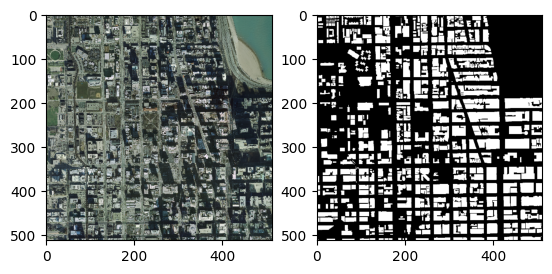

In [8]:
plt.subplot(1,2,1)
plt.imshow(X_train[65])

plt.subplot(1,2,2)
plt.imshow(y_train[65], cmap='gray')

In [9]:
# Load and preprocess GeoTIFF, image data as X test
X_test = load_geotiff_data(test_images_dir, target_shape=target_shape, normalize=True)

In [10]:
X_test.shape

(180, 512, 512, 3)

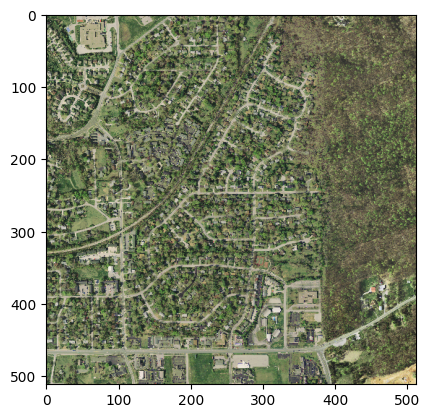

In [11]:
plt.imshow(X_test[65])

In [29]:
# Open the GeoTIFF file
folder_paths = [train_images_dir, test_images_dir, train_gt_dir]


# Create a list to store the dataframes
metadata_dfs = []

# Function to extract metadata from GeoTIFF files
def extract_metadata(folder_path):
    # Create an empty list to store the metadata
    metadata_list = []

    # Iterate over each file in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.tif') or filename.endswith('.tiff'):
            # Create the file path for the current GeoTIFF file
            file_path = os.path.join(folder_path, filename)

            try:
                # Open the GeoTIFF file
                dataset = gdal.Open(file_path)

                # Get the metadata
                width = dataset.RasterXSize
                height = dataset.RasterYSize
                crs = dataset.GetProjection()

                # Get the geotransform
                geotransform = dataset.GetGeoTransform()
                origin_x = geotransform[0]
                origin_y = geotransform[3]
                pixel_width = geotransform[1]
                pixel_height = geotransform[5]
                rotation_x = geotransform[2]
                rotation_y = geotransform[4]

                # Append the metadata to the list
                metadata_list.append({
                    'File': filename,
                    'Width': width,
                    'Height': height,
                    'CRS': crs,
                    'Origin_X': origin_x,
                    'Origin_Y': origin_y,
                    'Pixel_Width': pixel_width,
                    'Pixel_Height': pixel_height,
                    'Rotation_X': rotation_x,
                    'Rotation_Y': rotation_y
                })

                # Close the dataset
                dataset = None

            except Exception as e:
                print(f"Error opening file: {file_path}")
                print(f"Error message: {str(e)}")

    # Create a dataframe from the metadata list
    metadata_df = pd.DataFrame(metadata_list, columns=['File', 'Width', 'Height', 'CRS', 'Origin_X', 'Origin_Y',
                                                       'Pixel_Width', 'Pixel_Height', 'Rotation_X', 'Rotation_Y'])

    return metadata_df


# Extract metadata for train images
train_images_df = extract_metadata(train_images_dir)

# Extract metadata for test images
test_images_df = extract_metadata(test_images_dir)

# Extract metadata for train ground truth
train_gt_df = extract_metadata(train_gt_dir)

In [41]:
train_gt_df

,File,Width,Height,CRS,Origin_X,Origin_Y,Pixel_Width,Pixel_Height,Rotation_X,Rotation_Y
0,vienna34.tif,5000,5000,"PROJCS[""MGI / Austria GK East"",GEOGCS[""MGI"",DA...",2276.0,336911.0,0.3,-0.3,0.0,0.0
1,austin17.tif,5000,5000,"PROJCS[""NAD83 / UTM zone 14N"",GEOGCS[""NAD83"",D...",619500.0,3351000.0,0.3,-0.3,0.0,0.0
2,chicago2.tif,5000,5000,"PROJCS[""NAD83 / UTM zone 16N"",GEOGCS[""NAD83"",D...",439500.0,4633500.0,0.3,-0.3,0.0,0.0
3,kitsap36.tif,5000,5000,"PROJCS[""NAD83 / UTM zone 10N"",GEOGCS[""NAD83"",D...",529500.0,5263500.0,0.3,-0.3,0.0,0.0
4,kitsap31.tif,5000,5000,"PROJCS[""NAD83 / UTM zone 10N"",GEOGCS[""NAD83"",D...",528000.0,5263500.0,0.3,-0.3,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
175,austin23.tif,5000,5000,"PROJCS[""NAD83 / UTM zone 14N"",GEOGCS[""NAD83"",D...",621000.0,3351000.0,0.3,-0.3,0.0,0.0
176,vienna25.tif,5000,5000,"PROJCS[""MGI / Austria GK East"",GEOGCS[""MGI"",DA...",-2224.0,338411.0,0.3,-0.3,0.0,0.0
177,vienna30.tif,5000,5000,"PROJCS[""MGI / Austria GK East"",GEOGCS[""MGI"",DA...",5276.0,338411.0,0.3,-0.3,0.0,0.0
178,kitsap15.tif,5000,5000,"PROJCS[""NAD83 / UTM zone 10N"",GEOGCS[""NAD83"",D...",525000.0,5260500.0,0.3,-0.3,0.0,0.0


In [42]:
train_gt_df.to_csv('train_gt_df.csv')